In this notebook we will build a system which will predict the imdb rating of a movie on a scale of 10.
We will do this for bollywood movies since 1995.
Data for this is obtained from pages such as this :http://www.imdb.com/search/titlelanguages=hi|1&title_type=feature&sort=moviemeter,asc

In [2]:
%matplotlib inline
from bs4 import BeautifulSoup 
from pattern import web
import requests
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importing the necessary modules

We will use the requests module to scrape the data from the websites. The urllib module will be used to obtain the html for the url.


In [3]:
#r=urllib.urlopen("http://www.imdb.com/search/title?languages=hi|1&title_type=feature&sort=moviemeter,asc").read()
r=requests.get("http://www.imdb.com/search/title?languages=hi|1&title_type=feature&sort=moviemeter,asc")
#This is the url for the first 50 movies.
r.text #The HTML

u'    \n\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"\n        "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml">\n        <head>\n                <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n<script>\nvar addClickstreamHeadersToAjax = function(xhr) {\n    xhr.setRequestHeader("x-imdb-parent-id", "0N8DDXSXFJJXX8AQ9YAV");\n};\n</script>\n\n                <title>IMDb: Most Popular   Hindi-Language Feature Films\n</title>\n<link rel="canonical" href="http://www.imdb.com/search/title?languages=hi%7C1&title_type=feature&sort=moviemeter,asc" /><meta property="og:url" content="http://www.imdb.com/search/title?languages=hi%7C1&title_type=feature&sort=moviemeter,asc" />\n\n<link rel="stylesheet" type="text/css" href="http://i.media-imdb.com/images/SFf916c48ae9059d778bc2a0138c326bdf/css2/consumersite.css" ><link rel="stylesheet" type="text/css" href="http://i.media-imdb.com/images/SFd36761b30ebc061c8d30826d3d2

We will later write a function which will extract data from a set of imdb pages as above. But for the first 50 movies we will use the following code snippet as the url the first 50 movies is a bit different.


So, we first use the web object from the pattern module to get the html in the Document Object Notation(to see what this is , here's the wiki link :https://en.wikipedia.org/wiki/Document_Object_Model).
In the first step of out analysis, we will create a dataframe with the following variables: Title of the movie, The IMDB movies rating, Runtime of the movie in minutes, the genres, the director of the movie, the movie's cast and its release year.

In [4]:
#bs=BeautifulSoup(r)
#table= bs.find_all("div #content-2-wide")
d=web.Element(r.text)
titles=[]
ratings=[]
time=[]
gen=[]
directors=[]
casts=[]
years=[]
#for movie in dom.by_tag('td.title'):
    #titles.append(movie.by_tag('a')[0].content)
    #ratings.append(movie.by_tag('span.value')[0].content)
    #runtimes.append(movie.by_tag('span.runtime')[0].content)
    
#dom = web.Element(r.text)
d = web.Element(r.text)
for movie in d.by_tag('td.title'): #All the info bout the movie is inside the <td class="title"> tag.    
    title = movie.by_tag('a')[0].content  #The movie name.
    try:
        genres = movie.by_tag('span.genre')[0].by_tag('a') #The movie genre. Its the content of the <span class="genre">
        genres = [g.content for g in genres]
    except IndexError:
        genres=np.nan
        
    try:
        
            
        director=movie.by_tag('span.credit')[0].by_tag('a')[0].content
        
    except IndexError:
        director=np.nan    
    
    try:
        castings=movie.by_tag('span.credit')[0].by_tag('a')[1:]
        cast=[c.content for c in castings]
    except IndexError:
        cast=np.nan
        
    #We observe that some of the movies dont have ratings and runtimes and appending gives an IndexError. SO we use exception handling
    #and we append a NA value in such cases.
    
    #Basically, we use try and except for handling missing values.
    try:
        runtime = movie.by_tag('span.runtime')[0].content
    except IndexError:
        runtime=np.nan
    try:
        rating = movie.by_tag('span.value')[0].content
    except IndexError:
        rating=np.nan
    try:
        year=movie.by_tag('span.year_type')[0].content.split("(")[1].split(')')[0]
    except IndexError:
        year=np.nan
    #runtime = movie.by_tag('span.runtime')[0].content
    #rating = movie.by_tag('span.value')[0].content
    
    #Now we append the information got for each movie to the corresponding list.
    titles.append(title)
    gen.append(genres)
    time.append(runtime)
    ratings.append(rating)
    directors.append(director)
    casts.append(cast)
    years.append(year)
    
    #Create a dataframe. Its input is a dictionary and output is a dataframe with column names as the dictionary keys.
    df=pd.DataFrame({'Movie':titles, 'Genres':gen, 'Runtime':time, 'IMDB Rating':ratings,'Director':directors,'Cast':casts,'Year':years})
    #df[["IMDB Rating"]]=df[["IMDB Rating"]].astype(float)

In [5]:
df.shape

(50, 7)

We,now write a function to get data for 2000 movies. The code is almost same as that used for getting the data for the first 50 movies. For these pages the urls are of the type:
"http://www.imdb.com/search/title?languages=hi%7C1&sort=moviemeter,asc&start=[NUMBER OF THE FIRST MOVIE ON THE PAGE]&title_type=feature"

So we can write a function which takes in as input a number corresponding to the number of the first movie on the page.
example url: http://www.imdb.com/search/title?languages=hi%7C1&sort=moviemeter,asc&start=51&title_type=feature%22
In this url, the value of the "start" parameter is the argument to our function.


In [6]:
def movies_data(id):
    s1="http://www.imdb.com/search/title?languages=hi%7C1&sort=moviemeter,asc&start="
    s2= "%s&title_type=feature" %(id)
    url=s1 + s2   #Get the correct url.
    t=requests.get(url).text
    dom=web.Element(t)
    titles=[]
    gen=[]
    time=[]
    ratings=[]
    directors=[]
    casts=[]
    years=[]
    for movie in dom.by_tag('td.title'):
        title = movie.by_tag('a')[0].content
        try:
            genres = movie.by_tag('span.genre')[0].by_tag('a')
            genres = [g.content for g in genres]
        except IndexError:
            genres=np.nan
            
        try:
            
            director=movie.by_tag('span.credit')[0].by_tag('a')[0].content
        
        except IndexError:
            director=np.nan
            
        try:    
            castings=movie.by_tag('span.credit')[0].by_tag('a')[1:]
            cast=[c.content for c in castings]
        except IndexError:
            cast=np.nan
       
        #We observe that some of the movies dont have ratings and runtimes and appending gives an IndexError. SO we use exception handling
        #and we append a NA value in such cases.
        try:
            runtime = movie.by_tag('span.runtime')[0].content
        except IndexError:
            runtime=np.nan
        try:
            rating = movie.by_tag('span.value')[0].content
        except IndexError:
            rating= np.nan
            
        try:
            year=movie.by_tag('span.year_type')[0].content.split("(")[1].split(")")[0]
            
        except IndexError:
            year=np.nan
            
        #runtime = movie.by_tag('span.runtime')[0].content
        #rating = movie.by_tag('span.value')[0].content
        titles.append(title)
        gen.append(genres)
        time.append(runtime)
        ratings.append(rating)
        directors.append(director)
        casts.append(cast)
        years.append(year)
    df=pd.DataFrame({'Movie':titles, 'Genres':gen, 'Runtime':time, 'IMDB Rating':ratings,'Director':directors,'Cast':casts,'Year':years})
    #df[["IMDB Rating"]]=df[["IMDB Rating"]].astype(float)
    #print (url)
    return df


print movies_data("801").head()      

                                                Cast  \
0             [Asha Parekh, Manoj Kumar, Om Prakash]   
1         [Ajay Devgn, Akshay Kumar, Karisma Kapoor]   
2          [Sunny Deol, Juhi Chawla, Saurabh Shukla]   
3    [Juhi Chawla, Urmila Matondkar, Jimmy Shergill]   
4  [Mastan Alibhai Burmawalla, Ajay Devgn, Bipash...   

                   Director                    Genres IMDB Rating  \
0               Mohan Segal        [Mystery, Romance]         6.7   
1             Sandesh Kohli  [Action, Drama, Romance]         5.7   
2              Rahul Rawail         [Action, Romance]         5.1   
3                      Onir          [Drama, Romance]         6.0   
4  Abbas Alibhai Burmawalla        [Comedy, Thriller]         6.5   

          Movie Runtime  Year  
0         Sajan     NaN  1969  
1        Suhaag     NaN  1994  
2  Arjun Pandit     NaN  1999  
3    Bas Ek Pal     NaN  2006  
4     Mr. Fraud     NaN  2012  


Now we need to create a large data frame which contains data for all the 2000 movies. So, we go on appending th dataframes returned by succesive function calls to a copy of the original dataframe containing data for the first 50 movies.

In [7]:
df1=df.copy()
for i in range(51,5001,50):
    df1=df1.append(movies_data(i)) #Equivalent to a row-bind of the two dataframes.
    print df1.shape
    
#print df.shape    

(100, 7)
(150, 7)
(200, 7)
(250, 7)
(300, 7)
(350, 7)
(400, 7)
(450, 7)
(500, 7)
(550, 7)
(600, 7)
(650, 7)
(700, 7)
(750, 7)
(800, 7)
(850, 7)
(900, 7)
(950, 7)
(1000, 7)
(1050, 7)
(1100, 7)
(1150, 7)
(1200, 7)
(1250, 7)
(1300, 7)
(1350, 7)
(1400, 7)
(1450, 7)
(1500, 7)
(1550, 7)
(1600, 7)
(1650, 7)
(1700, 7)
(1750, 7)
(1800, 7)
(1850, 7)
(1900, 7)
(1950, 7)
(2000, 7)
(2050, 7)
(2100, 7)
(2150, 7)
(2200, 7)
(2250, 7)
(2300, 7)
(2350, 7)
(2400, 7)
(2450, 7)
(2500, 7)
(2550, 7)
(2600, 7)
(2650, 7)
(2700, 7)
(2750, 7)
(2800, 7)
(2850, 7)
(2900, 7)
(2950, 7)
(3000, 7)
(3050, 7)
(3100, 7)
(3150, 7)
(3200, 7)
(3250, 7)
(3300, 7)
(3350, 7)
(3400, 7)
(3450, 7)
(3500, 7)
(3550, 7)
(3600, 7)
(3650, 7)
(3700, 7)
(3750, 7)
(3800, 7)
(3850, 7)
(3900, 7)
(3950, 7)
(4000, 7)
(4050, 7)
(4100, 7)
(4150, 7)
(4200, 7)
(4250, 7)
(4300, 7)
(4350, 7)
(4400, 7)
(4450, 7)
(4500, 7)
(4550, 7)
(4600, 7)
(4650, 7)
(4700, 7)
(4750, 7)
(4800, 7)
(4850, 7)
(4900, 7)
(4950, 7)
(5000, 7)


The column names are in unicode format. We now convert them to ASCII.

In [8]:
for name in df1.columns:
    name.encode('ascii','ignore')
    

Remember that we are building a system which will predict IMDB ratings . For this its important that we consider only movies that are relatively recent.  So we will take movies released after or in 1988.(Thats the year when Aamir Khan, delivered his first superhit "Qayamat se Qayamat Tak". Salman Khan debuted around 1988 but and Shah Rukh Khan in 1992. These three being the most popular and successful actors in Bollywood, 1988 seems to be a pretty decent threshold.)

In [9]:
df_new=df1[df1.Year>="1988"] #Get only those movies after 1988.

In [10]:
df_new.shape #3156 movies

(3155, 7)

In [11]:
df_new.columns

Index([u'Cast', u'Director', u'Genres', u'IMDB Rating', u'Movie', u'Runtime', u'Year'], dtype='object')

We will now  expand our dataframe and make it wider. Our movie rating also depends on the genre of the movie. So we find all the unique genres in our data and create a separate column for each genre(The column corresponding to each genre will be a list of 0's and 1's. 1 if that genre is for that movie and 0 otherwise.

Now that we have got our data in a dataframe its time to clean it. We will filter out all the rows(that is all the movies which have missing entries for any of the variables.

In [12]:
from numpy import nan as NA
df_new=df_new.dropna()
df_new.shape

(1249, 7)

In [13]:
unique_genres=[] #List of the unique genres.

for gens in df_new.Genres:
    for g in gens:
        unique_genres.append(g)
    
unique_genres=set(unique_genres)  #set() function converts  list to all the unique elements in that list.     
        



In [14]:
len(unique_genres) #21 unique genres

21

In [15]:
unique_genres #List of the unique genres

{u'Action',
 u'Adventure',
 u'Animation',
 u'Biography',
 u'Comedy',
 u'Crime',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'History',
 u'Horror',
 u'Music',
 u'Musical',
 u'Mystery',
 u'News',
 u'Romance',
 u'Sci-Fi',
 u'Sport',
 u'Thriller',
 u'War',
 u'Western'}

This cell below will now get us our wide dataframe. The code is straightforward to follow.

In [16]:
#df_genres=pd.DataFrame({n:[1 if n in df_new.Genres] for n in unique_genres})
for g in unique_genres:
    l=[]
    for elem in df_new.Genres:
        if g in elem:
            l.append(1)
        else:
            l.append(0)
    df_new[g]=l       #Assigning the list to a new column in a dataframe

In [17]:
df_new.shape #The dataframe now has 1634 rows and 29 columns.

(1249, 28)

In [18]:
df_new.columns #the column names.

Index([u'Cast', u'Director', u'Genres', u'IMDB Rating', u'Movie', u'Runtime', u'Year', u'Mystery', u'Romance', u'Comedy', u'Sci-Fi', u'Family', u'Adventure', u'Horror', u'War', u'Crime', u'Drama', u'Fantasy', u'Western', u'Animation', u'Music', u'Biography', u'Action', u'News', u'Sport', u'Musical', u'Thriller', u'History'], dtype='object')

We will now do a similar process for the cast (actors) for each movie. For this we will uuse the list under the Cast column in our dataframe.

In [19]:
actors=[]
for c in df_new.Cast:
    for act in c:
        actors.append(act)

In [20]:
actors=set(actors)
len(actors) #1454 unique actors

1456

In [21]:
for act in actors:
    l=[]
    for elem in df_new.Cast:
        if act in elem:
            l.append(1)
        else:
            l.append(0)
    df_new[act]=l        

In [22]:
df_new.shape #Now dataframe has 1634 rows and 1478 columns. 

(1249, 1484)

Our data frame has only 1224 movies. This could have been much more.Remember that we dropped all those movies which had missing values for some field. This may not be a good approach always. So, from the original dataset scraped, we got only about 20% of the data which will be useful to us. We may be losing a lot of information here but I dont see any other way to deal with this!. If you see the imdb page, it has about 11,000 odd movies. But I didnt scrape all of them as it would have taken a lot of time and . We may as well get more than 6000 movies( only those movies after 1988) had we scraped all these 11,000-odd movies. One could try this!

The Runtime column in the dataframe has runtime of the movie in minutes and we know that. So we may as well get rid of the 'mins' and convert all the values to integer type.

In [23]:
df_new.Runtime 

0     156 mins.
1     163 mins.
2     170 mins.
3     126 mins.
4     120 mins.
5     123 mins.
6     153 mins.
7     128 mins.
8     136 mins.
9     320 mins.
10    172 mins.
11    104 mins.
12    170 mins.
13    180 mins.
14    146 mins.
...
24    124 mins.
29    109 mins.
1      77 mins.
21    112 mins.
31    119 mins.
45    250 mins.
23     78 mins.
38     95 mins.
17    133 mins.
39    115 mins.
16     88 mins.
9     139 mins.
36    138 mins.
38     99 mins.
43     63 mins.
Name: Runtime, Length: 1249, dtype: object

Now, we will get the runtime values in a range of (0,1). This is called as normalizing and this will be important for us.

In [24]:
y=[]
for f in df_new.Runtime:
    f=f.encode("ascii","ignore")
    f=f.split(" ")[0]
    if f!="NA":
        f=float(f)
        y.append(f)
    else:
        f="NA"
        y.append(f)
df_new.Runtime=y  

In [25]:
df_new.Runtime

0     156
1     163
2     170
3     126
4     120
5     123
6     153
7     128
8     136
9     320
10    172
11    104
12    170
13    180
14    146
...
24    124
29    109
1      77
21    112
31    119
45    250
23     78
38     95
17    133
39    115
16     88
9     139
36    138
38     99
43     63
Name: Runtime, Length: 1249, dtype: float64

In [26]:
#import numpy as np
m=float(min(df_new.Runtime))
M=float(max(df_new.Runtime))
type(m)
type(M)
f=[]
for d in df_new.Runtime:
    
    #print type(d)
    numerator=d-m
    denominator=M-m
    f.append(numerator/denominator) 
df_new.Runtime=f        

In [27]:
df_new.Runtime #Now all values which aren't NA's are in between 0 and 1.

0     0.364341
1     0.391473
2     0.418605
3     0.248062
4     0.224806
5     0.236434
6     0.352713
7     0.255814
8     0.286822
9     1.000000
10    0.426357
11    0.162791
12    0.418605
13    0.457364
14    0.325581
...
24    0.240310
29    0.182171
1     0.058140
21    0.193798
31    0.220930
45    0.728682
23    0.062016
38    0.127907
17    0.275194
39    0.205426
16    0.100775
9     0.298450
36    0.294574
38    0.143411
43    0.003876
Name: Runtime, Length: 1249, dtype: float64

We will now also normalize the year values.

In [28]:
year_min=float(min(df_new.Year))
year_max=float(max(df_new.Year))
#print type(year_min)
l=[]
for year in df_new.Year:
    l.append((float(year)-year_min)/(year_max-year_min))
    #print type(year)
    


In [29]:
df_new.Year=l

In [30]:
df_new.Year

0     1.000000
1     1.000000
2     0.777778
3     1.000000
4     1.000000
5     1.000000
6     0.962963
7     1.000000
8     1.000000
9     0.888889
10    0.925926
11    0.925926
12    1.000000
13    0.962963
14    0.962963
...
24    1.000000
29    0.666667
1     0.888889
21    0.851852
31    0.962963
45    0.666667
23    0.629630
38    0.333333
17    0.666667
39    0.888889
16    0.962963
9     0.037037
36    0.481481
38    1.000000
43    0.962963
Name: Year, Length: 1249, dtype: float64

In [35]:
#Writing the dataframe obtained to a csv file
df_new.to_csv("imdb.txt",sep=",",encoding='utf-8')

In [48]:
df_new.head(5)

,Cast,Director,Genres,IMDB Rating,Movie,Runtime,Year,Mystery,Romance,Comedy,...,Satyaraj,Hansa Vithal,Sandeep Bose,Jitin Gulati,Suman Ranganathan,Kader Khan,Seema Kelkar,Kriti Malhotra,Master Adil,Deep Dhillon
0,"[Akshay Kumar, Jackie Shroff, Sidharth Malhotra]",Karan Malhotra,"[Action, Drama, Sport]",7.1,Brothers,0.364341,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Ajay Devgn, Shriya Saran, Tabu]",Nishikant Kamat,"[Drama, Mystery, Thriller]",9.0,Drishyam,0.391473,1.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[Aamir Khan, Madhavan, Mona Singh]",Rajkumar Hirani,"[Comedy, Drama]",8.5,3 Idiots,0.418605,0.777778,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,"[Rishi Kapoor, Abhishek Bachchan, Asin]",Umesh Shukla,"[Comedy, Drama, Romance]",3.6,All Is Well,0.248062,1.000000,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,"[Nawazuddin Siddiqui, Radhika Apte, Ashutosh A...",Ketan Mehta,"[Biography, Drama, History, Romance]",8.7,Manjhi: The Mountain Man,0.224806,1.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#Exploratory Data Analysis

In [83]:
%matplotlib inline
k=[]
import matplotlib.pyplot as plt
for d in df_new['IMDB Rating']:
    d=d.encode("ascii","ignore")
    k.append(float(d))
    print type(d)
df_new['IMDB Rating']=l
#df_new.plot('Year','IMDB Rating')
#plt.plot(df_new['Year'],df_new['IMDB Rating'])
#plt.show()

AttributeError: 'numpy.float64' object has no attribute 'encode'

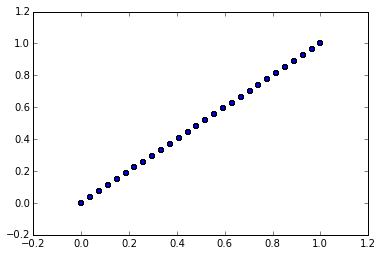

In [86]:
plt.scatter(list(df_new['Year']),list(df_new['IMDB Rating']))
plt.show()

#  Predicting.

Now for starters we will fit a linear model to the data.

Our dataframe now has many many columns. We will now peform PCA to compress the data.

In [30]:
from sklearn import linear_model
df_new.shape

(1248, 1482)

In [50]:
clf=linear_model.LinearRegression()

In [51]:
clf

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [52]:
df_new.columns

Index([u'Cast', u'Director', u'Genres', u'IMDB Rating', u'Movie', u'Runtime', u'Year', u'Mystery', u'Romance', u'Sport', u'Sci-Fi', u'Family', u'Biography', u'War', u'Crime', u'Drama', u'Fantasy', u'Western', u'Animation', u'Music', u'Adventure', u'Horror', u'Action', u'News', u'Comedy', u'Musical', u'Thriller', u'History', u'Manish Gupta', u'Sonakshi Sinha', u'Bunty Grewal', u'Abbas', u'Antara Mali', u'Tanushree Dutta', u'Rahul Roy', u'Garrick Chaudhary', u'Raajpal Yadav', u'Anil Kapoor', u'Inder Kumar', u'Anita Kanwar', u'Ravali', u'Karanvir Bohra', u'Vinay Pathak', u'Gayatri Joshi', u'Harsh Mayar', u'Krutika Deo', u'Mohnish Bahl', u'Aamir Bashir', u'Raja Gulati', u'Neten Chokling', u'Indravadan Tridevi', u'Aaran Chaudhary', u'Shernaz Patel', u'Raj Kesaria', u'Sidharth Malhotra', u'Emraan Hashmi', u'Keneth Desai', u'Aham Sharma', u'Joy Fernandes', u'Caterina Lopez', u'Suhasini', u'Mohan Azaad', u'Ranjeeta Kaur', u'Tabu', u'Mantra', u'Jamuna', u'Shadab Khan', u'Amruta Subhash', u'Ashi

In [53]:
cols=(list(df_new.columns))
cols.remove('IMDB Rating')
X,y= df_new[cols],df_new['IMDB Rating']


In [54]:
X.shape
X[3:].shape

(1225, 1457)

In [63]:
y.shape
x=X.ix[:,'Runtime':]#We want to exclude the first four variables from the features vector.
x=x[1:1000]
#We will use the last part of our dataframe as our test set and the first 1000 observations as the training set.
x


1    0.777778
1    0.703704
1    0.814815
1    0.370370
1    0.407407
1    0.777778
1    0.444444
1    0.629630
1    0.740741
1    0.666667
1    0.851852
1    0.888889
1    0.888889
1    0.185185
1    0.592593
1    0.592593
1    1.000000
1    0.518519
Name: Year, dtype: float64

In [56]:
clf=clf.fit(x,y[1:1000])

TypeError: unsupported operand type(s) for /: 'unicode' and 'long'

In [48]:
clf

SGDClassifier(alpha=0.0001, class_weight=None, epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', n_iter=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=False, verbose=0, warm_start=False)

In [49]:
x_test=X[1001:]
#x_test['Predicted Rating']=clf.predict[x_test,y[1001:]]
clf.predict[x_test]

TypeError: 'instancemethod' object has no attribute '__getitem__'